In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U keras
! pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

  Cloning https://github.com/tensorflow/examples.git to c:\users\msi1\appdata\local\temp\pip-req-build-po62oil0
  Resolved https://github.com/tensorflow/examples.git to commit 9084c2efc4837ecaa2544b43ea2f3c26b593dde4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1727910282.825055350737006839036646584288485110499677298148-py3-none-any.whl size=303818 sha256=856eef90a8f4f60de0e7db6040b1bf0f56aca520ea32edae4b932d572e29afc7
  Stored in directory: C:\Users\msi1\AppData\Local\Temp\pip-ephem-wheel-cache-1vw75yc1\wheels\ab\17\30\d16d07e2c95286770a9ddcd6f41629ea92b998858c5ee235aa
Successfully built tensorflow-examples


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\msi1\AppData\Local\Temp\pip-req-build-po62oil0'


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------------------------- ------------- 0.8/1.2 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\tqdm.exe' -> 'C:\\Python312\\Scripts\\tqdm.exe.deleteme'

ERROR: Could not find a version that satisfies the requirement tensorflow-text (from versions: none)
ERROR: No matching distribution found for tensorflow-text


In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\msi1\tensorflow_datasets\oxford_iiit_pet\incomplete.EZ2MIR_3.2.0\oxford_iiit_pet-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\msi1\tensorflow_datasets\oxford_iiit_pet\incomplete.EZ2MIR_3.2.0\oxford_iiit_pet-test.tfrec…

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\msi1\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['traia22rdn'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

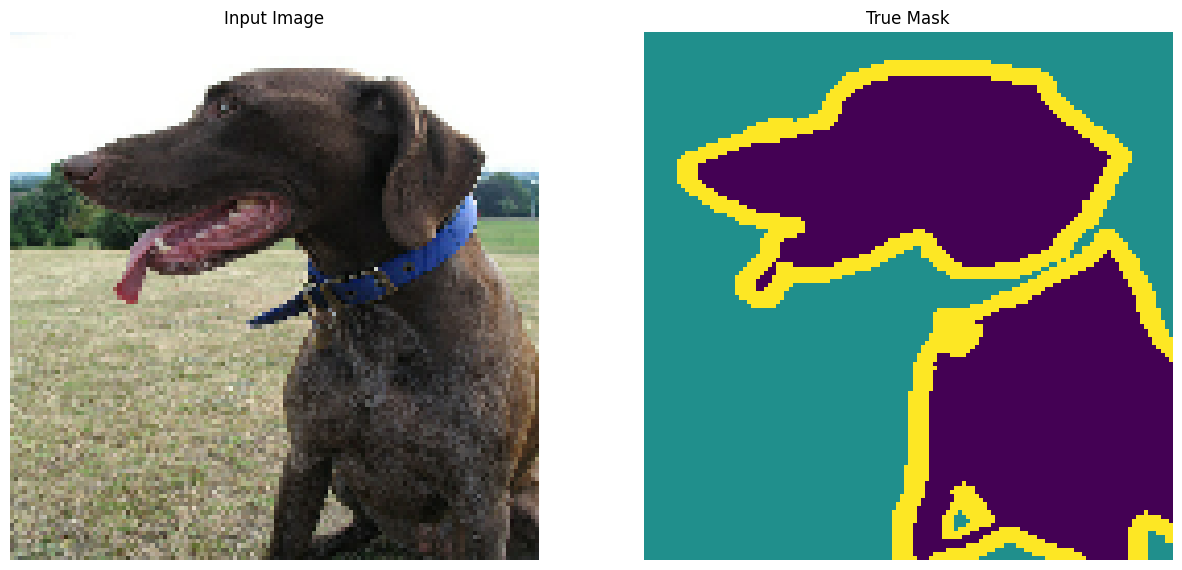

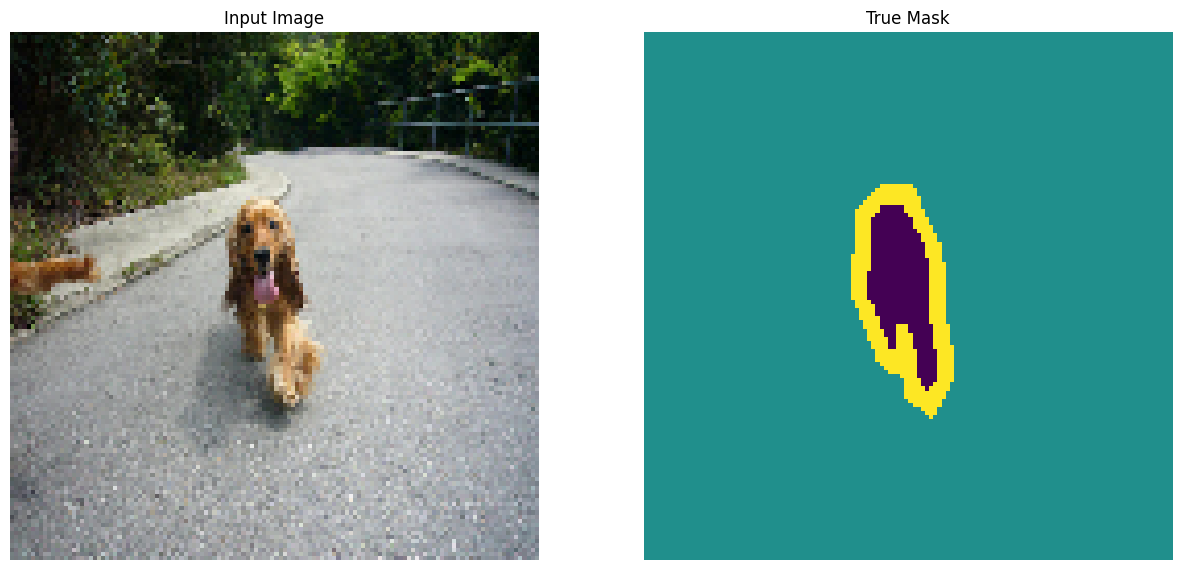

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])